In [1]:
%%capture
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from tensorflow.keras import regularizers
import os
import time
import numpy as np
import gc
import shutil
from tensorflow.keras.models import model_from_json
!pip install tqdm
!pip install h5py
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from sklearn import preprocessing

In [2]:
def scale(x):

    return (x - np.mean(x)) / np.std(x)

In [3]:
def preprocess(x):
    
    return x[:,:,:56]

In [4]:
path = "/home/pk2573/Capstone_Data/"

In [5]:
sets = ["Re1243Fr20", "Re309Fr2"]
timesteps = [1,2]
for data in sets:
    for time in timesteps:
        os.chdir(path + data + "/coarse8")
        u = preprocess(scale(loadmat("u_F_xyz_T" + str(time) + ".mat")["u_F"]))
        v = preprocess(scale(loadmat("v_F_xyz_T" + str(time) + ".mat")["v_F"]))
        w = preprocess(scale(loadmat("w_F_xyz_T" + str(time) + ".mat")["w_F"]))
        x = np.array([u, v, w])
        x = np.transpose(x, [1, 2, 3, 0])

        if data == "Re1243Fr20" and time == 1:
            Re1243Fr20_tau12_T1 = preprocess(scale(loadmat("tau12_F_xyz_T" + str(time) + ".mat")["tau12"]))
            Re1243Fr20_tau13_T1 = preprocess(scale(loadmat("tau13_F_xyz_T" + str(time) + ".mat")["tau13"]))
            Re1243Fr20_tau23_T1 = preprocess(scale(loadmat("tau23_F_xyz_T" + str(time) + ".mat")["tau23"]))
            Re1243Fr20_x_T1 = np.pad(x, ((3,3), (3,3), (3,3), (0,0)), 'constant', constant_values = 0)
        
        if data == "Re1243Fr20" and time == 2:
            Re1243Fr20_tau12_T2 = preprocess(scale(loadmat("tau12_F_xyz_T" + str(time) + ".mat")["tau12"]))
            Re1243Fr20_tau13_T2 = preprocess(scale(loadmat("tau13_F_xyz_T" + str(time) + ".mat")["tau13"]))
            Re1243Fr20_tau23_T2 = preprocess(scale(loadmat("tau23_F_xyz_T" + str(time) + ".mat")["tau23"]))
            Re1243Fr20_x_T2 = np.pad(x, ((3,3), (3,3), (3,3), (0,0)), 'constant', constant_values = 0)
        
        if data == "Re309Fr2" and time == 1:
            Re309Fr2_tau12_T1 = preprocess(scale(loadmat("tau12_F_xyz_T" + str(time) + ".mat")["tau12"]))
            Re309Fr2_tau13_T1 = preprocess(scale(loadmat("tau13_F_xyz_T" + str(time) + ".mat")["tau13"]))
            Re309Fr2_tau23_T1 = preprocess(scale(loadmat("tau23_F_xyz_T" + str(time) + ".mat")["tau23"]))
            Re309Fr2_x_T1 = np.pad(x, ((3,3), (3,3), (3,3), (0,0)), 'constant', constant_values = 0)
        
        if data == "Re309Fr2" and time == 2:
            Re309Fr2_tau12_T2 = preprocess(scale(loadmat("tau12_F_xyz_T" + str(time) + ".mat")["tau12"]))
            Re309Fr2_tau13_T2 = preprocess(scale(loadmat("tau13_F_xyz_T" + str(time) + ".mat")["tau13"]))
            Re309Fr2_tau23_T2 = preprocess(scale(loadmat("tau23_F_xyz_T" + str(time) + ".mat")["tau23"]))
            Re309Fr2_x_T2 = np.pad(x, ((3,3), (3,3), (3,3), (0,0)), 'constant', constant_values = 0)

#### Switches

In [6]:
all_taus = False

### 1. Generate Input Dataset

In [7]:
path = "/home/pk2573/"

In [8]:
print("Input Shapes")
print(Re309Fr2_x_T2.shape)
print(Re309Fr2_x_T1.shape)
print(Re1243Fr20_x_T2.shape)
print(Re1243Fr20_x_T1.shape)
print("\nOutput Shapes")
print(Re309Fr2_tau12_T2.shape)
print(Re309Fr2_tau12_T1.shape)
print(Re309Fr2_tau13_T2.shape)
print(Re309Fr2_tau13_T1.shape)
print(Re309Fr2_tau23_T2.shape)
print(Re309Fr2_tau23_T1.shape)

print(Re1243Fr20_tau12_T2.shape)
print(Re1243Fr20_tau12_T1.shape)
print(Re1243Fr20_tau13_T2.shape)
print(Re1243Fr20_tau13_T1.shape)
print(Re1243Fr20_tau23_T2.shape)
print(Re1243Fr20_tau23_T1.shape)

Input Shapes
(152, 102, 62, 3)
(152, 102, 62, 3)
(152, 102, 62, 3)
(152, 102, 62, 3)

Output Shapes
(146, 96, 56)
(146, 96, 56)
(146, 96, 56)
(146, 96, 56)
(146, 96, 56)
(146, 96, 56)
(146, 96, 56)
(146, 96, 56)
(146, 96, 56)
(146, 96, 56)
(146, 96, 56)
(146, 96, 56)


In [9]:
if not os.path.exists(path + "/Data"):
    os.mkdir(path + "/Data")
    os.mkdir(path + "/Data/Data")
    os.mkdir(path + "/Data/Labels")
    os.mkdir(path + "/Data/Labels/Tau_23")
    os.mkdir(path + "/Data/Labels/Tau_12")
    os.mkdir(path + "/Data/Labels/Tau_13")
else:
    shutil.rmtree(path + "/Data")
    os.mkdir(path + "/Data")
    os.mkdir(path + "/Data/Data")
    os.mkdir(path + "/Data/Labels")
    os.mkdir(path + "/Data/Labels/Tau_23")
    os.mkdir(path + "/Data/Labels/Tau_12")
    os.mkdir(path + "/Data/Labels/Tau_13")

In [10]:
sample = []
counter = 1
size = 3
y_tau_23 = []
y_tau_12 = []
y_tau_13 = []
num_files = 40

x_range = np.arange(size, Re1243Fr20_x_T1.shape[0] - size)
np.random.shuffle(x_range)
y_range = np.arange(size, Re1243Fr20_x_T1.shape[1] - size)
np.random.shuffle(y_range)
z_range = np.arange(size,Re1243Fr20_x_T1.shape[2] - size)
np.random.shuffle(z_range)

for i in tqdm_notebook(x_range):
    for j in y_range:
        for k in z_range:
            sample.append(Re1243Fr20_x_T1[i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, :])
            sample.append(Re1243Fr20_x_T2[i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, :])
            sample.append(Re309Fr2_x_T1[i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, :])
            sample.append(Re309Fr2_x_T2[i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, :])
            
            y_tau_23.append(Re1243Fr20_tau23_T1[i - size][j - size][k - size])
            y_tau_23.append(Re1243Fr20_tau23_T2[i - size][j - size][k - size])
            y_tau_23.append(Re309Fr2_tau23_T1[i - size][j - size][k - size])
            y_tau_23.append(Re309Fr2_tau23_T2[i - size][j - size][k - size])
            
            y_tau_13.append(Re1243Fr20_tau13_T1[i - size][j - size][k - size])
            y_tau_13.append(Re1243Fr20_tau13_T2[i - size][j - size][k - size])
            y_tau_13.append(Re309Fr2_tau13_T1[i - size][j - size][k - size])
            y_tau_13.append(Re309Fr2_tau13_T2[i - size][j - size][k - size])
            
            y_tau_12.append(Re1243Fr20_tau12_T1[i - size][j - size][k - size])
            y_tau_12.append(Re1243Fr20_tau12_T2[i - size][j - size][k - size])
            y_tau_12.append(Re309Fr2_tau12_T1[i - size][j - size][k - size])
            y_tau_12.append(Re309Fr2_tau12_T2[i - size][j - size][k - size])

            if len(sample) == 4* int(((Re1243Fr20_x_T1.shape[0] - size * 2) * (Re1243Fr20_x_T1.shape[1] - size * 2) * (Re1243Fr20_x_T1.shape[2] - size * 2)) / num_files):
                os.chdir(path + "/Data/Data")
                np.save(str(counter), np.array(sample))
                os.chdir(path + "/Data/Labels/Tau_23")
                np.save(str(counter), np.array(y_tau_23))
                os.chdir(path + "/Data/Labels/Tau_12")
                np.save(str(counter), np.array(y_tau_12))
                os.chdir(path + "/Data/Labels/Tau_13")
                np.save(str(counter), np.array(y_tau_13))

                del sample
                del y_tau_13
                del y_tau_12
                del y_tau_23
                gc.collect()
                sample = []
                y_tau_23 = []
                y_tau_12 = []
                y_tau_13 = []

                counter += 1
                
del Re309Fr2_x_T2
del Re309Fr2_x_T1
del Re1243Fr20_x_T2
del Re1243Fr20_x_T1
del Re309Fr2_tau12_T2
del Re309Fr2_tau12_T1
del Re309Fr2_tau13_T2
del Re309Fr2_tau13_T1
del Re309Fr2_tau23_T2
del Re309Fr2_tau23_T1
del Re1243Fr20_tau12_T2
del Re1243Fr20_tau12_T1
del Re1243Fr20_tau13_T2
del Re1243Fr20_tau13_T1
del Re1243Fr20_tau23_T2
del Re1243Fr20_tau23_T1
gc.collect()
print("Saved data to disk\n")


Saved data to disk



### 2. Create Model

In [11]:
class DNN(object):
    
    def __init__(self, activation, initializer, regularizer, input_shape):
        self.activation = activation
        self.initializer = initializer
        self.regularizer = regularizer
        self.input_shape = input_shape
        
        pass 
    
    def create_model(self):
        model = keras.Sequential([
            tf.keras.layers.Flatten(input_shape = self.input_shape),
            tf.keras.layers.Dense(128, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dense(1)
        ])
        
        return model

### 3. Run Model

Box size used: (7, 7, 7, 3)

Predicting Tau_12
Final Dataset Correlation: 0.8650
Saved model to disk


Predicting Tau_13
Final Dataset Correlation: 0.9075
Saved model to disk


Predicting Tau_23
Final Dataset Correlation: 0.8971
Saved model to disk



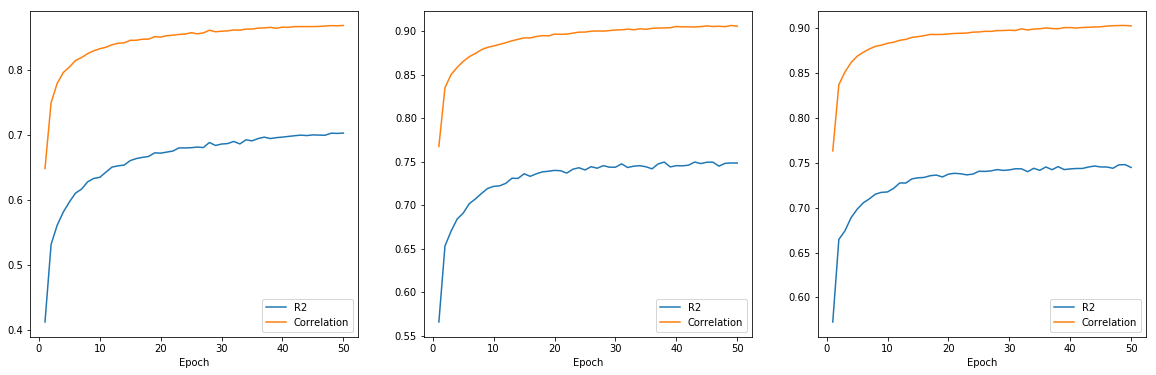

In [12]:
activation = tf.nn.relu
initializer = None
regularizer = None
epochs = 50
batch_size = 1000
val_split = 0.2

datasets = ["Tau_12", "Tau_13", "Tau_23"]
results = {}
i = 1
k = 1
print("Box size used: " + str((2 * size + 1, 2 * size + 1, 2 * size + 1, 3)))
fig = plt.figure(figsize = (20, 6))
for name in datasets:
    x_test = []
    y_test = []
    print("\nPredicting " + name)
    input_shape = (2 * size + 1, 2 * size + 1, 2 * size + 1, 3)
    neural_net = DNN(activation, initializer, regularizer, input_shape)
    model = neural_net.create_model()
    model.compile(optimizer = tf.train.AdamOptimizer(), loss = "mse")
    correlation = []
    R2 = []
    for i in range(epochs):
        #print("Epoch:", str(i))
        temp_1 = []
        temp_2 = []        
        files_range = np.arange(1, num_files + 1)
        np.random.shuffle(files_range)
        for j in files_range:
            # Load Datasets
            x = np.load(path + "/Data/Data/" + str(j) + ".npy")
            y = np.load(path + "/Data/Labels/" + name + "/" + str(j) + ".npy")
            
            # Create Train and Test sets
            mask =  np.random.rand(x.shape[0]) < 0.80
            x_train = x[mask,:,:,:,:]
            y_train = y[mask]
            x_test = x[~mask,:,:,:,:]
            y_test = y[~mask]
            del y
            del mask
            gc.collect()

            model.fit(x_train, y_train, epochs = 1, validation_split = 0.2, batch_size = batch_size, verbose = 0)
            del x_train
            del y_train
            gc.collect()
            
            # Get Test corr and R2 and append to list
            y_pred = model.predict(x_test).flatten()
            gc.collect()
            y_true = y_test.flatten()
            temp_1.append(r2_score(y_true, y_pred))
            temp_2.append(np.corrcoef(y_pred, y_true)[0, 1])
            del x_test
            del y_test
            del x
            gc.collect()
            i += 1
        
        # Get average Test corr and R2 for the epoch
        correlation.append(np.mean(temp_2))
        R2.append(np.mean(temp_1))
    
    # Plot R2 and corr evolution
    fig.add_subplot(1, len(datasets), k)
    plt.plot(np.arange(1, epochs + 1), np.array(R2), label = 'R2')
    plt.plot(np.arange(1, epochs + 1), np.array(correlation), label = 'Correlation')
    plt.xlabel('Epoch')
    plt.legend()
    print("Final Dataset Correlation: %.4f" % np.corrcoef(y_pred, y_true)[0, 1])
    del y_pred
    del y_true
    gc.collect()
    §
    os.chdir(path)
    model_name_json = "combined_time_model_" + name + ".json"
    model_name_h5 = "combined_time_model_" + name + ".h5"
    model_json = model.to_json()
    with open(model_name_json, "w") as json_file:
        json_file.write(model_json)
    model.save_weights(model_name_h5)
    print("Saved model to disk\n")
    
    k += 1